# Combining Natural Language Processing with Numeric/Categorical Features
In this notebook, I created a custom class to combine the NLP features of the condition description with the other descriptive features of the web-scraped eBay listings.

In [57]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config

import re  
import nltk
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

In [58]:
df = pd.read_csv('../data/nlp_iphones_cleaned.csv')

In [59]:
df = df.drop(columns=['Unnamed: 0', 'title'])

In [60]:
df

,price,condition,condition_description,num_reviews,pos_feedback_pct,return_days,model,capacity,release_year
0,135.99,1.0,“fully functional in excellent condition. our ...,30474.0,99.9,2.0,8,57.492355,2015
1,149.99,1.0,“overall good condition will have marks and sc...,13110.0,96.2,2.0,11,64.000000,2017
2,259.00,4.0,““pick your carrier or pick fully unlocked to ...,61033.0,100.0,2.0,11,256.000000,2017
3,107.99,1.0,“overall good working condition and will have ...,13110.0,96.2,2.0,10,32.000000,2016
4,209.95,3.0,"“this is a b+ stock item, meaning unit is in v...",332402.0,98.4,3.0,12,64.000000,2017
...,...,...,...,...,...,...,...,...,...
4141,456.99,3.0,“device is 100% fully functional and in very g...,54837.0,99.4,3.0,15,64.000000,2019
4142,335.00,1.0,“near mint condition: screen is 100% flawless....,22050.0,99.6,3.0,15,128.000000,2019
4143,591.00,1.0,“this is a used device with real photos of the...,80257.0,99.7,2.0,15,512.000000,2019
4144,149.99,1.0,“this device powers on and is 100% functional ...,4258.0,99.8,2.0,10,128.000000,2016


## Function to process descriptions

Created a function to pre-process all text in the condition description of listings.

In [61]:
def process_description(description, min_length):
    stop_words = stopwords.words('english')

    wnl = WordNetLemmatizer()

    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    description_lower = description.lower()
    description_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", description_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")

    description_norm = [x for x in word_tokenize(description_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(description_norm))) 

    if len(wordnet_tagged) <= min_length:
        return ''
    else:
        # rejoins lemmatized sentence 
        description_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return description_norm

In [62]:
df['condition_description'] = df['condition_description'].apply(process_description, args=[5])
# df['title'] = df['title'].apply(process_description, args=[5])

In [63]:
df

,price,condition,condition_description,num_reviews,pos_feedback_pct,return_days,model,capacity,release_year
0,135.99,1.0,fully functional excellent condition device pr...,30474.0,99.9,2.0,8,57.492355,2015
1,149.99,1.0,overall good condition mark scratch mfi charge...,13110.0,96.2,2.0,11,64.000000,2017
2,259.00,4.0,pick carrier pick fully unlocked work multiple...,61033.0,100.0,2.0,11,256.000000,2017
3,107.99,1.0,overall good work condition mark scratch charg...,13110.0,96.2,2.0,10,32.000000,2016
4,209.95,3.0,stock item mean unit good cosmetic condition m...,332402.0,98.4,3.0,12,64.000000,2017
...,...,...,...,...,...,...,...,...,...
4141,456.99,3.0,device fully functional good physical conditio...,54837.0,99.4,3.0,15,64.000000,2019
4142,335.00,1.0,mint condition screen flawless wear frame negl...,22050.0,99.6,3.0,15,128.000000,2019
4143,591.00,1.0,use device real photo exact unique item actual...,80257.0,99.7,2.0,15,512.000000,2019
4144,149.99,1.0,device power functional ready use condition no...,4258.0,99.8,2.0,10,128.000000,2016


# Data Exploration

Viewing the collinearity of different features of the data

<AxesSubplot:>

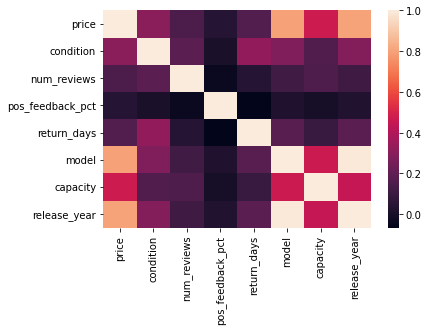

In [64]:
sns.heatmap(df.corr())

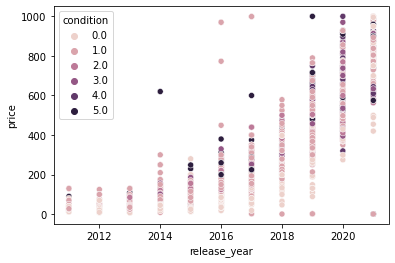

In [65]:
sns.scatterplot(y='price', x='release_year', hue='condition', data=df)
plt.show()

## Filtering by Price

In the following cells, I filtered out any listings below $40, as these listings are usually accessories or cases, rather than actual devices.

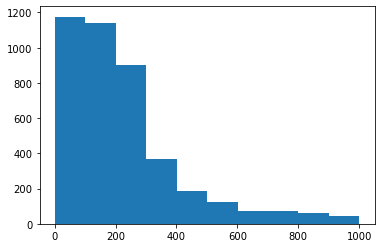

In [66]:
plt.hist(df['price']);

In [67]:
df = df[df['price']>40]

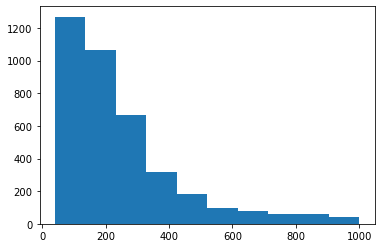

In [68]:
plt.hist(df['price']);

## Train/Test Split

I decided to drop the Model from the features because of its collinearity with Release Year, and because Release Year is a more universal feature that can be extended to other devices.

In [69]:
df.columns

Index(['price', 'condition', 'condition_description', 'num_reviews',
       'pos_feedback_pct', 'return_days', 'model', 'capacity', 'release_year'],
      dtype='object')

In [70]:
X = df.drop(columns = ['price', 'model'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=305)

# Pipeline

I decided to use a column transformer, so I separated my features into numeric, natural language, and categorical columns. Then, a custom class was created to incorporate the Sentiment Intensity Analysis as a feature of the model. Finally, the pipeline was created to unite all features and run them through the model.

In [71]:
nlp_cols = 'condition_description'
num_cols = ['num_reviews', 'pos_feedback_pct', 'capacity', 'condition_neg', 'condition_neu', 'condition_pos', 'condition_compound']
cat_cols = ['condition', 'return_days', 'capacity', 'release_year']

In [72]:
# Create custom class for Sentiment Intensity Analysis

class SentimentDataFramer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y = 0):
        return self
    def transform(self, data, y = 0):
        polarity_list = []
        polarity_list.extend(data.apply(self.sentiment))
        polarity_df = pd.DataFrame(polarity_list)
        return polarity_df
    def sentiment(self, desc):
        sia = SentimentIntensityAnalyzer()
        scores = sia.polarity_scores(desc)
        return scores

In [73]:
transformer_list = [
    ('nlpvect', TfidfVectorizer(stop_words = 'english', ngram_range=(1,3))),
    ('sentint', SentimentDataFramer())
]

feat_union = FeatureUnion(transformer_list)

In [74]:
numeric_pipeline = Pipeline([('numnorm', StandardScaler())])

categoric_pipeline = Pipeline([('ordnorm', StandardScaler())])

nlp_pipeline = Pipeline([('nlp', feat_union)])

In [75]:
ct = ColumnTransformer(
    [ ("nlppipeline", nlp_pipeline, nlp_cols),
      ("numericpipe", numeric_pipeline, num_cols),
      ("categoricpipeline", categoric_pipeline, cat_cols)
    ]
)

In [76]:
ct

ColumnTransformer(transformers=[('nlppipeline',
                                 Pipeline(steps=[('nlp',
                                                  FeatureUnion(transformer_list=[('nlpvect',
                                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                                               3),
                                                                                                  stop_words='english')),
                                                                                 ('sentint',
                                                                                  SentimentDataFramer())]))]),
                                 'condition_description'),
                                ('numericpipe',
                                 Pipeline(steps=[('numnorm',
                                                  StandardScaler())]),
                                 ['num_reviews', 'pos_feedback_pct', 'capacity',
                                  'condition_neg', 'condition_neu',
                                  'condition_pos', 'condition_compound']),
                                ('categoricpipeline',
                                 Pipeline(steps=[('ordnorm',
                                                  StandardScaler())]),
                                 ['condition', 'return_days', 'capacity',
                                  'release_year'])])

In [77]:
set_config(display="diagram")

In [78]:
final_pipe = Pipeline([('preprocess', ct),
                      ('model', GradientBoostingRegressor())])
final_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nlppipeline',
                                                  Pipeline(steps=[('nlp',
                                                                   FeatureUnion(transformer_list=[('nlpvect',
                                                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                                                3),
                                                                                                                   stop_words='english')),
                                                                                                  ('sentint',
                                                                                                   SentimentDataFramer())]))]),
                                                  'condition_description'),
                                                 ('numericpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  ['num_reviews',
                                                   'pos_feedback_pct',
                                                   'capacity', 'condition_neg',
                                                   'condition_neu',
                                                   'condition_pos',
                                                   'condition_compound']),
                                                 ('categoricpipeline',
                                                  Pipeline(steps=[('ordnorm',
                                                                   StandardScaler())]),
                                                  ['condition', 'return_days',
                                                   'capacity',
                                                   'release_year'])])),
                ('model', GradientBoostingRegressor())])

In [79]:
final_pipe.fit(X_train, y_train)

ValueError: A given column is not a column of the dataframe

In [56]:
y_pred = final_pipe.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)

print('RMSE: '+str(rmse))
print('R-Squared: '+str(r_squared))

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [ ]:
param_grid = {'model__n_estimators' : [500],
              'model__max_depth' : range(5,10),
              'model__min_samples_split' : [2, 3, 4, 5, 6, 7],
              'model__learning_rate' : [0.01, 0.02, 0.03],
              'model__subsample': [0.9, 0.5, 0.2, 0.1]
              }

In [37]:
# grid_GBR = GridSearchCV(estimator=final_pipe, param_grid = param_grid, cv = 2, n_jobs=-1)
# grid_GBR.fit(X_train, y_train)

    

In [38]:
# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
# print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
# print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

In [39]:
params = {
    "n_estimators": 500,
    "max_depth": 9,
    "min_samples_split": 7,
    "learning_rate": 0.02,
    "loss": 'lad',
    "subsample":0.5
}

best_xgboost = GradientBoostingRegressor(**params)

In [40]:
gs_pipe = Pipeline([('preprocess', ct),
                      ('model', best_xgboost)])
gs_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nlppipeline',
                                                  Pipeline(steps=[('nlp',
                                                                   FeatureUnion(transformer_list=[('nlpvect',
                                                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                                                3),
                                                                                                                   stop_words='english')),
                                                                                                  ('sentint',
                                                                                                   SentimentDataFramer())]))]),
                                                  'condition_description'),
                                                 ('numericpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  ['num_reviews',
                                                   'pos_feedback_pct',
                                                   'capacity', 'condition_neg',
                                                   'condition_neu',
                                                   'condition_pos',
                                                   'condition_compound']),
                                                 ('categoricpipeline',
                                                  Pipeline(steps=[('ordnorm',
                                                                   StandardScaler())]),
                                                  ['condition', 'return_days',
                                                   'capacity',
                                                   'release_year'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.02, loss='lad',
                                           max_depth=9, min_samples_split=7,
                                           n_estimators=500, subsample=0.5))])

In [41]:
gs_pipe.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [42]:
y_pred = gs_pipe.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)

print('RMSE: '+str(rmse))
print('R-Squared: '+str(r_squared))

NameError: name 'X_test' is not defined

In [43]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import warnings
warnings.filterwarnings('ignore')

In [44]:
w_feedbackpctg = widgets.FloatSlider(
    value=90,
    min=70.0,
    max=100.0,
    step=0.1,
    description='Positive Feedback Percentage:',
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.1f',
)

In [45]:
w_feedbackpctg

FloatSlider(value=90.0, continuous_update=False, description='Positive Feedback Percentage:', min=70.0, orient…

In [627]:
w_condition = widgets.Dropdown(
    options=['Broken or For Parts', 'Used', 'Good - Refurbished', 'Very Good - Refurbished', 'Excellent - Refurbished', 'Open Box', 'New'],
    value='Good - Refurbished',
    description='Condition: ',
    disabled=False,
)

In [628]:
w_condition

Dropdown(description='Condition: ', index=2, options=('Broken or For Parts', 'Used', 'Good - Refurbished', 'Ve…

In [629]:
condition_dict = {
    'for parts or not working': 0,
    'used': 1,
    'good - refurbished': 2,
    'very good - refurbished': 3,
    'excellent - refurbished': 4,
    'open box': 5,
    'new': 6
}

In [630]:
w_capacity = widgets.Dropdown(
    options=['16 GB', '32 GB', '64 GB', '128 GB', '256 GB', '512 GB'],
    value='64 GB',
    description='Capacity: ',
    disabled=False,
)

In [631]:
w_capacity

Dropdown(description='Capacity: ', index=2, options=('16 GB', '32 GB', '64 GB', '128 GB', '256 GB', '512 GB'),…

In [632]:
float(re.findall('[0-9]+', w_capacity.value)[0])

64.0

In [633]:
w_condition_description = widgets.Textarea(
    value='',
    placeholder='Type description',
    description='Description:',
    disabled=False
)

In [634]:
w_condition_description

Textarea(value='', description='Description:', placeholder='Type description')

In [635]:
w_num_reviews = widgets.Text( 
    value='',
    placeholder='Type number of reviews',
    description='# Reviews:',
    disabled=False
)

In [636]:
w_num_reviews

Text(value='', description='# Reviews:', placeholder='Type number of reviews')

In [637]:
w_return_days = widgets.Dropdown(
    options=['Seller does not accept returns', '14 days returns', '30 days returns', '60 days returns'],
    value='14 days returns',
    description='Returns: ',
    disabled=False,
)

In [638]:
w_return_days

Dropdown(description='Returns: ', index=1, options=('Seller does not accept returns', '14 days returns', '30 d…

In [639]:
return_dict = {
    'Seller does not accept returns': 0,
    '14 days returns': 1,
    '30 days returns': 2,
    '60 days returns': 3
}

In [640]:
w_release_year = widgets.Text( 
    value='',
    placeholder='Type Release Year',
    description='Release Yr:',
    disabled=False
)

In [641]:
w_release_year

Text(value='', description='Release Yr:', placeholder='Type Release Year')

In [662]:
@interact
def show_widgets(a = w_feedbackpctg,b = w_capacity,c= w_condition,d= w_condition_description,e= w_num_reviews,f= w_return_days,g= w_release_year):
    


    sample_dict = {
        'pos_feedback_pct':a,
        'capacity':b,
        'condition':c,
        'condition_description':d,
        'num_reviews':e,
        'return_days':f,
        'release_year':g
    }
    series = pd.Series(sample_dict)


    return series

interactive(children=(FloatSlider(value=90.0, continuous_update=False, description='Positive Feedback Percenta…

In [647]:
gs_pipe.predict(X_test.iloc[0].array)

IndexError: tuple index out of range

In [576]:
X_test.iloc[0]

condition                                                              4.0
condition_description    device come excellent physical condition scree...
num_reviews                                                        54835.0
pos_feedback_pct                                                      99.4
return_days                                                            3.0
capacity                                                         69.467626
release_year                                                          2016
condition_neg                                                        0.033
condition_neu                                                        0.826
condition_pos                                                        0.141
condition_compound                                                  0.8126
Name: 1762, dtype: object